# NBA MVP Predictions
#### Shane Huang

## Introduction

At the end of every NBA season, the league honors the most significant players with a series of awards such as Rookie of the Year, Most Improved Player, and Defenseive Player of the Year. Of all these awards, the most important one is the Most Valuable Player award (MVP). Since the 1980-81 season, the MVP award has been decided by a selected panel of sports journalists and broadcasters from the US and Canada. The NBA league itself does not specify a set standard or guideline by which voters should follow when casting their votes, as such there is not one clear metric or statistic that clearly determine which player each year deserves the title of MVP.

For this project, I looked at some of the metrics found on the basketball statistics website Basketball-Reference.com and used those to try to predict the winner of the MVP award. I focused on using the seasons from 1999-00 to 2018-19 to see if I could build a model to predict the MVP of the 2019-20 season. In short, the question at hand is whether one can use player and team metrics to predict who will win the MVP.

## Data Collection and Cleaning

The specific data that I used for this analysis were from the Most Valuable Player table on the NBA Awards Voting page for each season and the Conference Standings tables on the NBA Season Summary page for each season. The Most Valuable Player table contains each of the players that received at least one MVP vote that season. For each of these MVP candidates, the table provides various of statistics such as points per game and shooting percentage. I know MVP voting is heavily affected by how well a player's team performs so I pulled the Win/Loss percentage and Simple Rating System (simple metric used to describe how good a team is) from the Conference Standings.

### Data Collection

To pull the data I needed, I set up a for loop to go through each year from 2000 to 2020. Inside the loop I adjusted the url for the NBA Awards Voting and NBA Season Summary pages so I could pull them year by year. Then I used the read_html function from the pandas library to read in the tables from each page. Both tables contained some columns that I didn't plan on using so I dropped those.

For both tables, I added a 'Year' column so a player's metrics and team's summaries were tied with their specific season.

For the team summary tables I had to combine separate tables for the Eastern Conference and the Western Conference. Also, Basketball-Reference.com doesn't have a specific column indicating whether a team made the playoffs that season but instead has an asterisk next to the team name. To address this, I removed the asterisk and instead created a separate column to indicate a playoff appearance. 

I then combined each season's tables so by the end of the for loop I had two large tables for all seasons from 1999-00 to 2019-2020, one containing the individual metrics of MVP contenders and the other containing season summaries for every team.

In [1]:
import pandas as pd
import numpy as np

In [2]:
### Loop through past 20 years to get MVP and team statistics

# Initialize MVP and team datasets
mvp_data = pd.DataFrame(columns = ['Rank','Player','Age','Tm','Share','G','MP','PTS','TRB','AST','STL','BLK','FG%','3P%','FT%','WS','WS/48','Year'])
team_data = pd.DataFrame(columns = ['Team Name','W/L%','SRS','Playoffs','Year'])

for year in range(2000,2021):
    ## MVP Data
    # Create url
    mvp_urlparts = ['https://www.basketball-reference.com/awards/awards_',str(year),'.html']
    mvp_url = "".join(mvp_urlparts)
    
    # Read in html tables
    mvp_dfs = pd.read_html(mvp_url)
    
    # Pull and format MVP table
    mvp = mvp_dfs[0]
    mvp.columns = mvp.columns.get_level_values(1)
    mvp['Year'] = year
    
    # Drop unnecessary columns (additional voting numbers)
    mvp = mvp.drop(mvp.columns[[4,5,6]], axis=1)
    
    # Append single year data to total dataset
    mvp_data = mvp_data.append(mvp, ignore_index=True)
    
    
    
    ## Team Data
    # Create url
    team_urlparts = ['https://www.basketball-reference.com/leagues/NBA_',str(year),'_standings.html']
    team_url = "".join(team_urlparts)
    
    # Read in html tables
    team_dfs = pd.read_html(team_url)
    
    # Pull and combine Eastern and Western Conference tables
    team_e = team_dfs[0]
    team_w = team_dfs[1]
    team_e.rename(columns={team_e.columns[0]: "Team Name"}, inplace=True)
    team_w.rename(columns={team_w.columns[0]: "Team Name"}, inplace=True)
    team = pd.concat([team_e,team_w]).reset_index(drop=True)
    
    # Team names have an '*' if they made the playoffs
    # Create column to identify playoff appearance and remove '*' from names
    team['Playoffs'] = team['Team Name'].str.contains('\*')
    team['Team Name'] = team['Team Name'].str.replace('*','')
    
    # Create year id
    team['Year'] = year
    
    # Select drop unnecessary columns (Win column, Loss column, etc.)
    team = team.drop(team.columns[[1,2,4,5,6]], axis=1)
    
    # Append single year data to total data
    team_data = team_data.append(team, ignore_index=True)

In [3]:
# MVP Table
mvp_data

,Rank,Player,Age,Tm,Share,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Year
0,1,Shaquille O'Neal,27,LAL,0.998,79,40.0,29.7,13.6,3.8,0.5,3.0,0.574,0.000,0.524,18.6,0.283,2000
1,2,Kevin Garnett,23,MIN,0.337,81,40.0,22.9,11.8,5.0,1.5,1.6,0.497,0.370,0.765,11.6,0.172,2000
2,3,Alonzo Mourning,29,MIA,0.303,79,34.8,21.7,9.5,1.6,0.5,3.7,0.551,0.000,0.711,12.9,0.226,2000
3,4,Karl Malone,36,UTA,0.258,82,35.9,25.5,9.5,3.7,1.0,0.9,0.509,0.250,0.797,15.3,0.249,2000
4,5,Tim Duncan,23,SAS,0.205,74,38.9,23.2,12.4,3.2,0.9,2.2,0.490,0.091,0.761,13.0,0.218,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,8,Damian Lillard,29,POR,0.023,66,37.5,30.0,4.3,8.0,1.1,0.3,0.463,0.401,0.888,11.6,0.225,2020
295,9,Nikola Jokić,24,DEN,0.018,73,32.0,19.9,9.7,7.0,1.2,0.6,0.528,0.314,0.817,9.8,0.202,2020
296,10,Pascal Siakam,25,TOR,0.017,60,35.2,22.9,7.3,3.5,1.0,0.9,0.453,0.359,0.792,5.4,0.123,2020
297,11,Jimmy Butler,30,MIA,0.009,58,33.8,19.9,6.7,6.0,1.8,0.6,0.455,0.244,0.834,9.0,0.221,2020


In [4]:
# Team Summary Table
team_data

,Team Name,W/L%,SRS,Playoffs,Year
0,Atlantic Division,Atlantic Division,Atlantic Division,False,2000
1,Miami Heat,.634,2.75,True,2000
2,New York Knicks,.610,1.30,True,2000
3,Philadelphia 76ers,.598,1.02,True,2000
4,Orlando Magic,.500,0.43,False,2000
...,...,...,...,...,...
706,San Antonio Spurs,0.451,-0.65,False,2020
707,Sacramento Kings,0.431,-1.59,False,2020
708,New Orleans Pelicans,0.417,-0.55,False,2020
709,Minnesota Timberwolves,0.297,-4.02,False,2020


### Cleaning Tables

Once I had the two large tables for MVP and team metrics, I performed some simple cleaning.

For the team season summaries I started by converting a couple columns to their appropriate data types. Because not all season summary tables are formatted the same across all seasons on Basketball-Reference.com, some rows ended up having NaNs so I had to drop those.

Then for the MVP tables, I created an 'MVP' column by indicating which player each season received the most MVP votes. There were also a handful of players who never shot a 3-pointer so they did not have a value for their 3-point percentage. I simply filled in those missing values with 0 since those types of players were not the type to shoot 3s anyway.

Each player in the MVP tables also has a team acronym that I would use as a key to merge in their respective team statistics. I found that three MVP contenders across all 20 seasons had played for more than one team during their MVP contending season and their team acronym was marked 'TOT' instead of a normal team acronym. Because of this I wouldn't be able to merge in their team statistics. Because none of these three players received many MVP votes, I decided to just drop them from the table.

In [5]:
### Additional Cleaning

# Convert 'W/L%' and 'SRS' to floats and drop rows of '...Division'
team_data[['W/L%','SRS']] = team_data[['W/L%','SRS']].apply(pd.to_numeric, errors='coerce')
team_data.dropna(inplace=True)

# Create 'MVP' column based on 'Rank' column (then drop 'Rank')
mvp_data['Rank'] = mvp_data['Rank'].apply(pd.to_numeric, errors='coerce')
mvp_data['MVP'] = mvp_data['Rank'] == 1
mvp_data.drop(columns=['Rank'], inplace=True)

# Fill in 3P% NaNs with 0
mvp_data['3P%'] = mvp_data['3P%'].fillna(0)

# Drop players listed under team 'TOT'
mvp_data.drop(mvp_data[mvp_data['Tm']=='TOT'].index, inplace=True)

### Merging Tables

Now that I had cleaned the two tables, I had to merge them together. Like mentioned earlier, the MVP table had a team acronym for each player, however, the team summary table only has the teams' full names. To merge the two tables together I had to go through and find all the teams that existed over the past 20 seasons (there were a few teams that changed locations and team names) and their matching acronymns. I then created a key to match the full team names with their acronymns and attached the key to the team summary tables. Then I merged the two tables together on the team acronym and season. At the end of this process I had one large table with every MVP contender over the past 20 seasons, their individual season metrics, and their team's season metrics.

In [6]:
## Merge two datasets together
# Create key to connect team name with acronym
names = sorted(team_data['Team Name'].unique())
abbr = ['ATL','BOS','BRK','CHA','CHO','CHI','CLE','DAL','DEN','DET','GSW','HOU','IND','LAC','LAL','MEM','MIA','MIL','MIN','NJN','NOH','NOP','NOK','NYK','OKC','ORL','PHI','PHO','POR','SAC','SAS','SEA','TOR','UTA','VAN','WAS']

key = pd.DataFrame(list(zip(names,abbr)), columns=['Team Name','Tm'])

# Add key to team_data
team_data = team_data.join(key.set_index('Team Name'), on='Team Name')

# Charlotte Hornets during 2000-2002 had a different acronym
team_data.loc[(team_data['Team Name']=='Charlotte Hornets') & (team_data['Year'].isin([2000,2001,2002])),'Tm'] = 'CHH'

# Drop team names
team_data.drop(columns=['Team Name'], inplace=True)

# Combine datasets
data = pd.merge(mvp_data, team_data, how='left', on=['Tm','Year'])

### Data Description

In [7]:
# Final Cleaned Data
data

,Player,Age,Tm,Share,G,MP,PTS,TRB,AST,STL,...,FG%,3P%,FT%,WS,WS/48,Year,MVP,W/L%,SRS,Playoffs
0,Shaquille O'Neal,27,LAL,0.998,79,40.0,29.7,13.6,3.8,0.5,...,0.574,0.000,0.524,18.6,0.283,2000,True,0.817,8.41,True
1,Kevin Garnett,23,MIN,0.337,81,40.0,22.9,11.8,5.0,1.5,...,0.497,0.370,0.765,11.6,0.172,2000,False,0.610,2.67,True
2,Alonzo Mourning,29,MIA,0.303,79,34.8,21.7,9.5,1.6,0.5,...,0.551,0.000,0.711,12.9,0.226,2000,False,0.634,2.75,True
3,Karl Malone,36,UTA,0.258,82,35.9,25.5,9.5,3.7,1.0,...,0.509,0.250,0.797,15.3,0.249,2000,False,0.671,4.52,True
4,Tim Duncan,23,SAS,0.205,74,38.9,23.2,12.4,3.2,0.9,...,0.490,0.091,0.761,13.0,0.218,2000,False,0.646,5.92,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,Damian Lillard,29,POR,0.023,66,37.5,30.0,4.3,8.0,1.1,...,0.463,0.401,0.888,11.6,0.225,2020,False,0.473,-0.61,True
292,Nikola Jokić,24,DEN,0.018,73,32.0,19.9,9.7,7.0,1.2,...,0.528,0.314,0.817,9.8,0.202,2020,False,0.630,2.35,True
293,Pascal Siakam,25,TOR,0.017,60,35.2,22.9,7.3,3.5,1.0,...,0.453,0.359,0.792,5.4,0.123,2020,False,0.736,5.97,True
294,Jimmy Butler,30,MIA,0.009,58,33.8,19.9,6.7,6.0,1.8,...,0.455,0.244,0.834,9.0,0.221,2020,False,0.603,2.59,True


#### The following are the descriptions of each variable in the final dataset:
Age -- Player's age on February 1 of the season
<br>Tm -- Team
<br>Share -- Percentage of MVP votes received
<br>G -- Games Played
<br>MP -- Minutes Played Per Game
<br>PTS -- Points Per Game
<br>TRB -- Total Rebounds Per Game
<br>AST -- Assists Per Game
<br>STL -- Steals Per Game
<br>BLK -- Blocks Per Game
<br>FG% -- Field Goal Percentage
<br>3P% -- 3-Point Field Goal Percentage
<br>FT% -- Free Throw Percentage
<br>WS -- Win Shares
<br>&emsp;&emsp;An estimate of the number of wins contributed by a player.
<br>WS/48 -- Win Shares Per 48 Minutes
<br>&emsp;&emsp;An estimate of the number of wins contributed by a player per 48 minutes (league average is approximately .100)
<br>Year -- Season
<br>MVP -- Awarded MVP or not
<br>W/L% -- Win/Loss Percentage
<br>SRS -- Simple Rating System.
<br>&emsp;&emsp;A team rating that takes into account average point differential and strenght of schedule. The rating is denominated in points above/below average, where zero is average.

All the variables listed above were used as the explanatory variables except 'Share' and 'MVP'. I created two types of models: regression models and classification models. For regression models I used 'Share' as the response variable and for classification models I used 'MVP' as the response variable.

## Exploratory Data Analysis

To visually explore the data, I created some scatterplots of various explanatory variables against 'Share'. I also colored the points according to whether the player won MVP or not. The explanatory variables I chose to plot were the main metrics I see often cited when discussing MVP: points per game, field-goal percentage, win share, win/loss percentage, and simple rating system. For the most part, they all followed a similar pattern: slightly positive linear relationship. W/L% had the strongest looking relationship and FG% had the weakest. However none of the relationships were particularly strong so I don't believe any single one of these metrics is the main deciding point for winning MVP.

In [8]:
import matplotlib.pyplot as plt

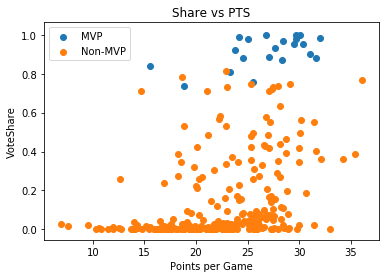

In [9]:
# Share vs PTS
plt.scatter(data.loc[data['MVP']==True]['PTS'], data.loc[data['MVP']==True]['Share'], label='MVP')
plt.scatter(data.loc[data['MVP']==False]['PTS'], data.loc[data['MVP']==False]['Share'], label='Non-MVP')
plt.ylabel('VoteShare')
plt.xlabel('Points per Game')
plt.title('Share vs PTS')
plt.legend(loc='upper left');

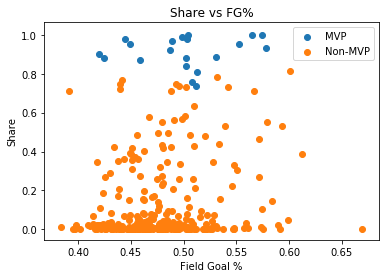

In [10]:
# Share vs FG%
plt.scatter(data.loc[data['MVP']==True]['FG%'], data.loc[data['MVP']==True]['Share'], label='MVP')
plt.scatter(data.loc[data['MVP']==False]['FG%'], data.loc[data['MVP']==False]['Share'], label='Non-MVP')
plt.ylabel('Share')
plt.xlabel('Field Goal %')
plt.title('Share vs FG%')
plt.legend(loc='upper right');

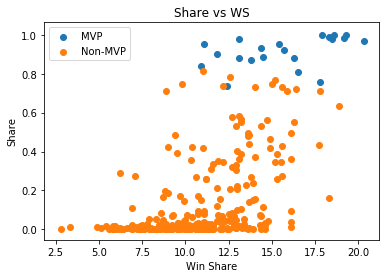

In [11]:
# Share vs WS
plt.scatter(data.loc[data['MVP']==True]['WS'], data.loc[data['MVP']==True]['Share'], label='MVP')
plt.scatter(data.loc[data['MVP']==False]['WS'], data.loc[data['MVP']==False]['Share'], label='Non-MVP')
plt.ylabel('Share')
plt.xlabel('Win Share')
plt.title('Share vs WS')
plt.legend(loc='upper left');

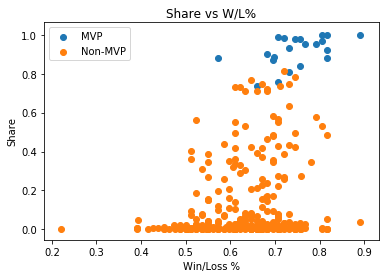

In [12]:
# Share vs W/L%
plt.scatter(data.loc[data['MVP']==True]['W/L%'], data.loc[data['MVP']==True]['Share'], label='MVP')
plt.scatter(data.loc[data['MVP']==False]['W/L%'], data.loc[data['MVP']==False]['Share'], label='Non-MVP')
plt.ylabel('Share')
plt.xlabel('Win/Loss %')
plt.title('Share vs W/L%')
plt.legend(loc='upper left');

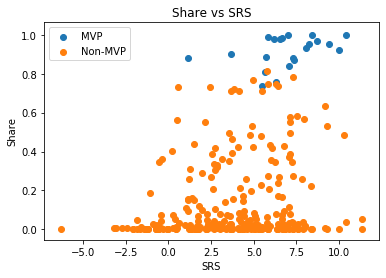

In [13]:
# Share vs SRS
plt.scatter(data.loc[data['MVP']==True]['SRS'], data.loc[data['MVP']==True]['Share'], label='MVP')
plt.scatter(data.loc[data['MVP']==False]['SRS'], data.loc[data['MVP']==False]['Share'], label='Non-MVP')
plt.ylabel('Share')
plt.xlabel('SRS')
plt.title('Share vs SRS')
plt.legend(loc='upper left');

## Modeling

As mentioned earlier, I will be performing both regression and classification with a variety of models. For each model I simply used the default hyperparameters.

To begin the modeling process, I first split the data into training and testing datasets. As mentioned in the introduction, all the seasons from 1999-00 to 2018-19 were used as training data and the 2019-20 season was used at the testing data.

### Set Up

In [14]:
# Set up training and testing data
# 2020 will be the testing data. All years before 2020 will be the training data

X_train = data.loc[data['Year']!=2020].drop(['Share','MVP'], axis=1)
X_test = data.loc[data['Year']==2020].drop(['Share','MVP'], axis=1)

names_test = data.loc[data['Year']==2020, 'Player'].reset_index(drop=True)

I then set up a simple pre-processing pipeline. The original data didn't have many issues to address during pre-processing so I just scaled the data and encoded the categorical variables.

In [15]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler

In [16]:
class ColumnExtractor(TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        Xcols = X[self.cols]
        return Xcols

In [17]:
#  Numerical features
numeric_columns = X_train.select_dtypes(exclude='object').columns

#  Categorical features
categorical_columns = X_train.select_dtypes('object').columns

#  Define the pipeline to fix the data
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('numeric', Pipeline([
            ('extract', ColumnExtractor(numeric_columns)),
            ('scale', MinMaxScaler())
            #('scale', StandardScaler())
        ])),
        ('categorical', Pipeline([
            ('extract', ColumnExtractor(categorical_columns)),
            ('encode', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ])),
    ]))
])

### Regression

In [18]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

For regression, I tested the following models:
<br>Simple Linear Regression
<br>Lasso
<br>K Nearest Neighbors
<br>Ridge
<br>Decision Tree

For each model I calculated the root mean squared error, R^2 score, and mean absolute error. I also predicted the MVP voting share for the 2019-20 season. The predicted share results were not especially accurate, likely because in reality all the shares total up to 1.0 so the observed response variables aren't really independent and the model would not be able to account for that. Instead, I was primarily interested if the models were at least able to identify the player that received the highest MVP voting share.

In [19]:
y_train = data.loc[data['Year']!=2020, 'Share']
y_test = data.loc[data['Year']==2020, 'Share']

#### Simple Linear Regression

The simple linear regression model produced really good evaluation metrics, however the actual predicted MVP voting shares were extremely off. They were all extremely large or extremely negative and the model did not predict the correct player to receive the highest share of votes.

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
lr_pipeline = Pipeline([('pipeline', pipeline),
                         ('lr', LinearRegression())])

lr_pipeline.fit(X_train, y_train);

In [22]:
yhat_train = lr_pipeline.predict(X_train)

rmse = np.sqrt(mean_squared_error(y_train, yhat_train))
print('RMSE:',rmse)
print('R^2:',r2_score(y_train, yhat_train))
print('MAE:',mean_absolute_error(y_train, yhat_train))

RMSE: 0.10708460533805864
R^2: 0.8540659137215534
MAE: 0.0726642636581206


In [23]:
yhat = lr_pipeline.predict(X_test)
pd.concat([names_test,pd.Series(yhat).rename('Predicted Share')], axis=1)

,Player,Predicted Share
0,Giannis Antetokounmpo,-2.350358e+11
1,LeBron James,-2.350358e+11
2,James Harden,-2.350358e+11
3,Luka Dončić,-4.497884e+11
4,Kawhi Leonard,-1.328451e+10
5,Anthony Davis,6.846019e+11
6,Chris Paul,-2.350358e+11
7,Damian Lillard,-2.350358e+11
8,Nikola Jokić,-2.350358e+11
9,Pascal Siakam,-4.422826e+11


#### Lasso

Compared to simple linear regression, the lasso regression model did not produce as good of evaluation metrics. However, the predicted 'Share' values were much more reasonable. The model however, did not accurately choose which player should receive the highest share of votes, choosing LeBron James and James Harden over the actual MVP, Giannis Antetokounmpo.

In [24]:
from sklearn.linear_model import LassoCV

In [25]:
%%capture
lasso_pipeline = Pipeline([('pipeline', pipeline),
                         ('lasso', LassoCV())])

lasso_pipeline.fit(X_train, y_train);

In [26]:
yhat_train = lasso_pipeline.predict(X_train)

rmse = np.sqrt(mean_squared_error(y_train, yhat_train))
print('RMSE:',rmse)
print('R^2:',r2_score(y_train, yhat_train))
print('MAE:',mean_absolute_error(y_train, yhat_train))

RMSE: 0.19531505249431594
R^2: 0.5145169275390007
MAE: 0.14734798592777296


In [27]:
yhat = lasso_pipeline.predict(X_test)
pd.concat([names_test,pd.Series(yhat).rename('Predicted Share')], axis=1)

,Player,Predicted Share
0,Giannis Antetokounmpo,0.351539
1,LeBron James,0.388909
2,James Harden,0.354375
3,Luka Dončić,0.147723
4,Kawhi Leonard,0.135874
5,Anthony Davis,0.268409
6,Chris Paul,0.053655
7,Damian Lillard,0.191727
8,Nikola Jokić,0.148300
9,Pascal Siakam,-0.010729


#### K Nearest Neighbors

The KNN model performed similarly to the lasso model. The evaluation metrics for both models were similar and both models chose James and Harden over Antetokounmpo.

In [28]:
from sklearn.neighbors import KNeighborsRegressor

In [29]:
knn_pipeline = Pipeline([('pipeline', pipeline),
                         ('knn', KNeighborsRegressor())])

knn_pipeline.fit(X_train, y_train);

In [30]:
yhat_train = knn_pipeline.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, yhat_train))
print('RMSE:',rmse)
print('R^2:',r2_score(y_train, yhat_train))
print('MAE:',mean_absolute_error(y_train, yhat_train))

RMSE: 0.20436885632752294
R^2: 0.4684647249043934
MAE: 0.14952464788732395


In [31]:
yhat = knn_pipeline.predict(X_test)
pd.concat([names_test,pd.Series(yhat).rename('Predicted Share')], axis=1)

,Player,Predicted Share
0,Giannis Antetokounmpo,0.2042
1,LeBron James,0.3420
2,James Harden,0.3180
3,Luka Dončić,0.0034
4,Kawhi Leonard,0.1802
5,Anthony Davis,0.1750
6,Chris Paul,0.0660
7,Damian Lillard,0.0608
8,Nikola Jokić,0.1254
9,Pascal Siakam,0.0202


#### Ridge

The ridge model was the first model to perform well. It had the best evaluation metrics (except for simple linear regression) and it accurately chose Giannis Antetokounmpo as the player who received the largest share of MVP votes.

In [32]:
from sklearn.linear_model import Ridge

In [33]:
ridge_pipeline = Pipeline([('pipeline', pipeline),
                         ('ridge', Ridge())])

ridge_pipeline.fit(X_train, y_train);

In [34]:
yhat_train = ridge_pipeline.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, yhat_train))
print('RMSE:',rmse)
print('R^2:',r2_score(y_train, yhat_train))
print('MAE:',mean_absolute_error(y_train, yhat_train))

RMSE: 0.13855764005759047
R^2: 0.7556774131927618
MAE: 0.10116927340244353


In [35]:
yhat = ridge_pipeline.predict(X_test)
pd.concat([names_test,pd.Series(yhat).rename('Predicted Share')], axis=1)

,Player,Predicted Share
0,Giannis Antetokounmpo,0.668925
1,LeBron James,0.251614
2,James Harden,0.432387
3,Luka Dončić,-0.036323
4,Kawhi Leonard,0.257511
5,Anthony Davis,0.228880
6,Chris Paul,-0.040314
7,Damian Lillard,0.142152
8,Nikola Jokić,0.222334
9,Pascal Siakam,-0.144631


#### Decision Tree

The decision tree model had by far and away the best evaluation metrics. However, the predicted voting shares were quite off. It chose James Harden as the clear winner without an obvious second place.

In [36]:
from sklearn.tree import DecisionTreeRegressor

In [37]:
tree_pipeline = Pipeline([('pipeline', pipeline),
                         ('tree', DecisionTreeRegressor())])

tree_pipeline.fit(X_train, y_train);

In [38]:
yhat_train = tree_pipeline.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, yhat_train))
print('RMSE:',rmse)
print('R^2:',r2_score(y_train, yhat_train))
print('MAE:',mean_absolute_error(y_train, yhat_train))

RMSE: 1.0293690016637802e-19
R^2: 1.0
MAE: 2.4432725013757847e-20


In [39]:
yhat = tree_pipeline.predict(X_test)
pd.concat([names_test,pd.Series(yhat).rename('Predicted Share')], axis=1)

,Player,Predicted Share
0,Giannis Antetokounmpo,0.025
1,LeBron James,0.029
2,James Harden,0.404
3,Luka Dončić,0.001
4,Kawhi Leonard,0.029
5,Anthony Davis,0.049
6,Chris Paul,0.001
7,Damian Lillard,0.003
8,Nikola Jokić,0.001
9,Pascal Siakam,0.001


When looking at all the models, it becomes clear that predicting MVP voting share is not the appropriate approach - primarily due to the dependent nature of the variable. The decision tree performed the best in terms of evaluation metrics, however these metrics don't mean much if the model isn't able to properly predict the testing data. The only model to accurately choose the MVP was the ridge model.

### Classification

In [40]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

For classification, I tested the following models:
<br>Naive Bayes
<br>Random Forest
<br>ADA Boosted Forest

For the evaluation metrics I used accuracy score and F1 score along with a confusion matrix on the training data. I also predicted which player would win MVP in the 2019-20 season. I didn't constrain the models to only pick a single player so they could've picked multiple players or none at all.

In [41]:
y_train = data.loc[data['Year']!=2020, 'MVP']
y_test = data.loc[data['Year']==2020, 'MVP']

#### Naive Bayes

The naive bayes classification model did not perform very well. It essentially just predicted none of the players (in either the training or testing data) to win MVP. The accuracy score appeared decent primarily because the majority of players in the data weren't MVP. Because the model didn't predict any player to win MVP, the F1 score was 0.

In [42]:
from sklearn.naive_bayes import MultinomialNB

In [43]:
nb = Pipeline([('pipeline', pipeline),
                ('nb', MultinomialNB())])

nb.fit(X_train, y_train);

In [44]:
yhat_train = nb.predict(X_train)

print('Accuracy Score:',accuracy_score(y_train, yhat_train))
print('F1 Score:',f1_score(y_train, yhat_train))

print('Confusion Matrix:')
confusion_matrix(y_train, yhat_train)

Accuracy Score: 0.9295774647887324
F1 Score: 0.0
Confusion Matrix:


array([[264,   0],
       [ 20,   0]], dtype=int64)

In [45]:
yhat = nb.predict(X_test)
pd.concat([names_test,pd.Series(yhat).rename('MVP')], axis=1)

,Player,MVP
0,Giannis Antetokounmpo,False
1,LeBron James,False
2,James Harden,False
3,Luka Dončić,False
4,Kawhi Leonard,False
5,Anthony Davis,False
6,Chris Paul,False
7,Damian Lillard,False
8,Nikola Jokić,False
9,Pascal Siakam,False


#### Random Forest

The random forest model performed well in the evaluation metrics by predicting all the actual MVP winners from the training data. However, it was not able to predict the MVP of the 2019-20 season and instead did not predict a winner.

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
rf = Pipeline([('pipeline', pipeline),
                ('rf', RandomForestClassifier())])

rf.fit(X_train, y_train);

In [48]:
yhat_train = rf.predict(X_train)

print('Accuracy Score:',accuracy_score(y_train, yhat_train))
print('F1 Score:',f1_score(y_train, yhat_train))

print('Confusion Matrix:')
confusion_matrix(y_train, yhat_train)

Accuracy Score: 1.0
F1 Score: 1.0
Confusion Matrix:


array([[264,   0],
       [  0,  20]], dtype=int64)

In [49]:
yhat = rf.predict(X_test)
pd.concat([names_test,pd.Series(yhat).rename('MVP')], axis=1)

,Player,MVP
0,Giannis Antetokounmpo,False
1,LeBron James,False
2,James Harden,False
3,Luka Dončić,False
4,Kawhi Leonard,False
5,Anthony Davis,False
6,Chris Paul,False
7,Damian Lillard,False
8,Nikola Jokić,False
9,Pascal Siakam,False


#### ADA Boosted

The ADA boosted model was the best model. It got perfect evaluation metrics and also perfectly predicted Giannis Antetokounmpo as the MVP of the 2019-20 season and did not falsely predict anyone else to win.

In [50]:
from sklearn.ensemble import AdaBoostClassifier

In [51]:
ada = Pipeline([('pipeline', pipeline),
                ('ada', AdaBoostClassifier())])

ada.fit(X_train, y_train);

In [52]:
yhat_train = ada.predict(X_train)

print('Accuracy Score:',accuracy_score(y_train, yhat_train))
print('F1 Score:',f1_score(y_train, yhat_train))

print('Confusion Matrix:')
confusion_matrix(y_train, yhat_train)

Accuracy Score: 1.0
F1 Score: 1.0
Confusion Matrix:


array([[264,   0],
       [  0,  20]], dtype=int64)

In [53]:
yhat = ada.predict(X_test)
pd.concat([names_test,pd.Series(yhat).rename('MVP')], axis=1)

,Player,MVP
0,Giannis Antetokounmpo,True
1,LeBron James,False
2,James Harden,False
3,Luka Dončić,False
4,Kawhi Leonard,False
5,Anthony Davis,False
6,Chris Paul,False
7,Damian Lillard,False
8,Nikola Jokić,False
9,Pascal Siakam,False


The classification models did not perform that much better than the regression models. With the classification models, I think a big issue is the imbalace of the reponse variable. Less than 10% of all the players in the training dataset won MVP and only one of the 11 players in the testing dataset won. This is probably why two of the three models didn't predict any MVP for the testing data.

## Conclusion

After fitting five regression models and three classification models, only two of the models (one in each category) were able to accurately predict the MVP winner of the 2019-20 season. The ridge regression model correctly predicted Giannis Antetokounmpo to receive the largest share of MVP votes and the ADA boosted classification model correctly predicted Antetokounmpo and no one else to win MVP.

None of these models were specifically tuned, so if I went through and tuned the hyperparameters I may have gotten more models to accurately predict the MVP winner. Also, this data is inherently difficult to work with given the depedence of the quantitative response and the sparcity of the categorical response as I detailed in each of the respective sections.

That being said, having even two un-tuned models correctly predict the MVP shows that there is some rhyme or reason even in a competition as debatable and undefined as the Most Valuable Player award.

I am excited to use these models at the end of the upcoming NBA season and see if I can predict the MVP winner before the results come out!